In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.9MB/s 


In [0]:
link = 'https://drive.google.com/open?id=17WwtkoQXmh-aakunX52RTTADaZ2OAw9K' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ASX200Monthly.csv')

In [4]:
!pip install -q pmdarima

     |████████████████████████████████| 921kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels as sm 
import statsmodels.api as smt
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [0]:
# Reading data
monthly_data = pd.read_csv('ASX200Monthly.csv')

In [7]:
# Converting to a time series
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
monthly_data.set_index('Date', inplace = True)
monthly_ts = pd.Series(monthly_data['Close'])
print(monthly_ts.head())

Date
2000-02-29            NaN
2000-03-31    3115.800049
2000-04-30    3081.000000
2000-05-31    3311.199951
2000-06-30    3251.100098
Name: Close, dtype: float64


In [0]:
# Removing missing values
monthly_ts.dropna(inplace=True)

In [0]:
# Splitting data into training and validation subsets
training_subset = monthly_ts[:-12]
validation_subset = monthly_ts[-12:]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


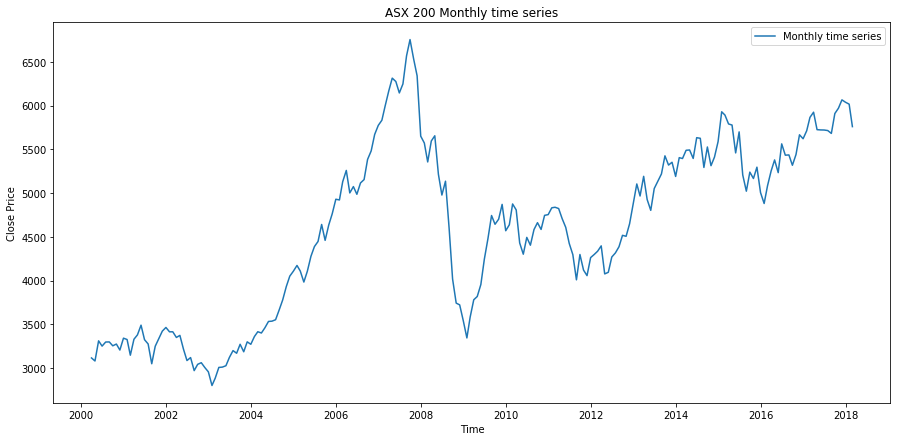

In [10]:
# Setting figure width and height
rcParams['figure.figsize'] = 15, 7

# Plotting time series
plt.plot(training_subset, label = "Monthly time series")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('ASX 200 Monthly time series')
plt.legend()

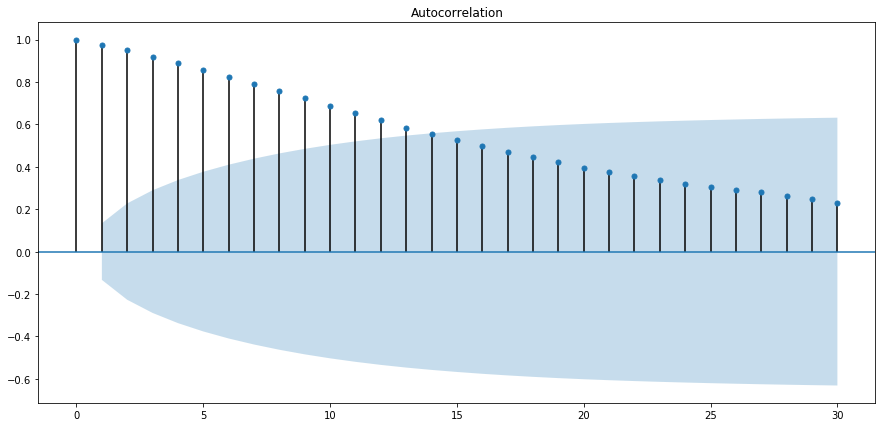

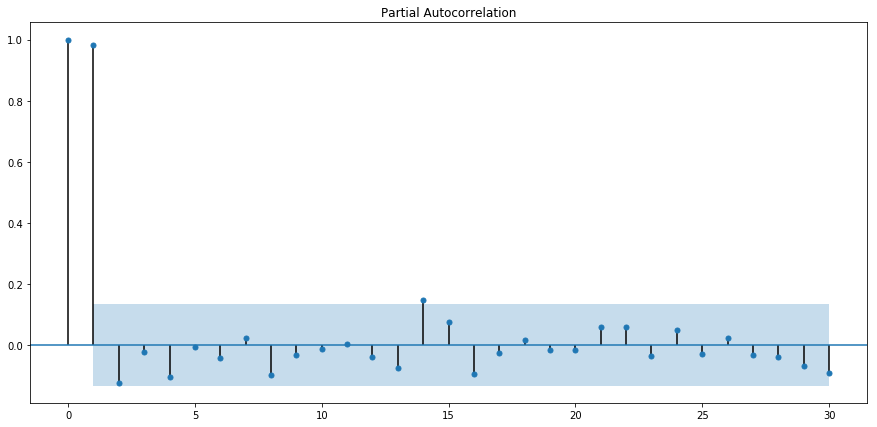

In [11]:
# ACF plot of the original data
smt.graphics.tsa.plot_acf(training_subset, lags = 30, alpha = 0.05)
plt.show()

# PACF plot of the original data
smt.graphics.tsa.plot_pacf(training_subset, lags = 30, alpha = 0.05)
plt.show()

As we can see from the plots above, ACF does not die down quickly which means that the time series is non-stationary. We will apply transformations to the data to make it stationary.

In [0]:
# Transforming time series by taking log
# It reduces variation in data by penalizing larger values more than the smaller ones
training_subset_log = np.log(training_subset)

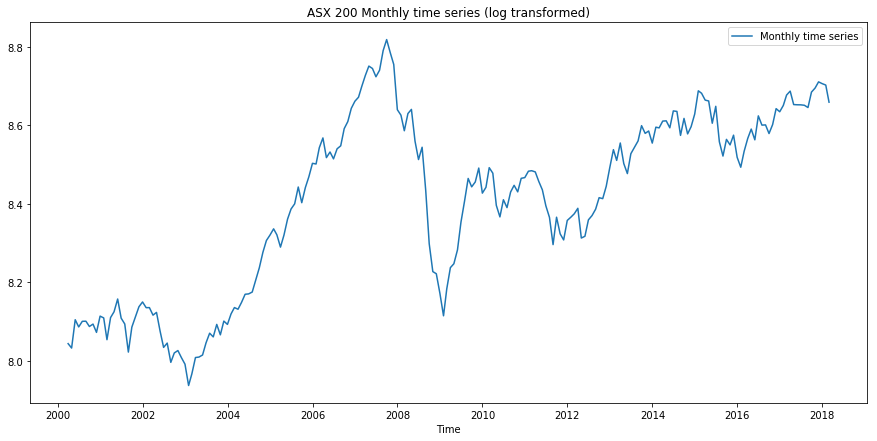

In [13]:
# Plotting log transformed time series
plt.plot(training_subset_log, label = "Monthly time series")
plt.xlabel('Time')
plt.title('ASX 200 Monthly time series (log transformed)')
plt.legend()

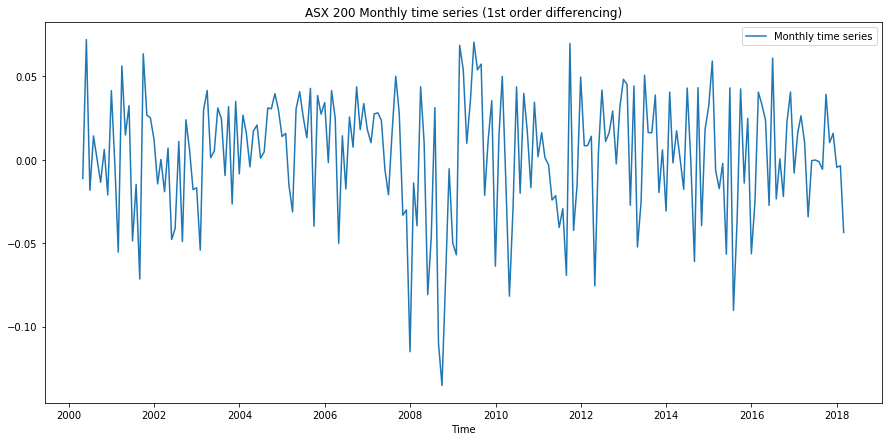

In [14]:
# Applying first order differencing to make the data stationary
monthly_ts_diff = training_subset_log.diff()
monthly_ts_diff.dropna(inplace = True)

# Plotting time series
plt.plot(monthly_ts_diff, label = "Monthly time series")
plt.xlabel('Time')
plt.title('ASX 200 Monthly time series (1st order differencing)')
plt.legend()

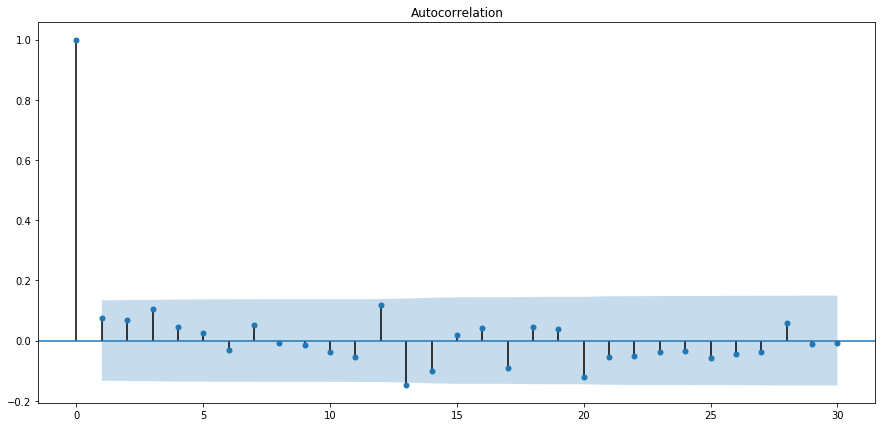

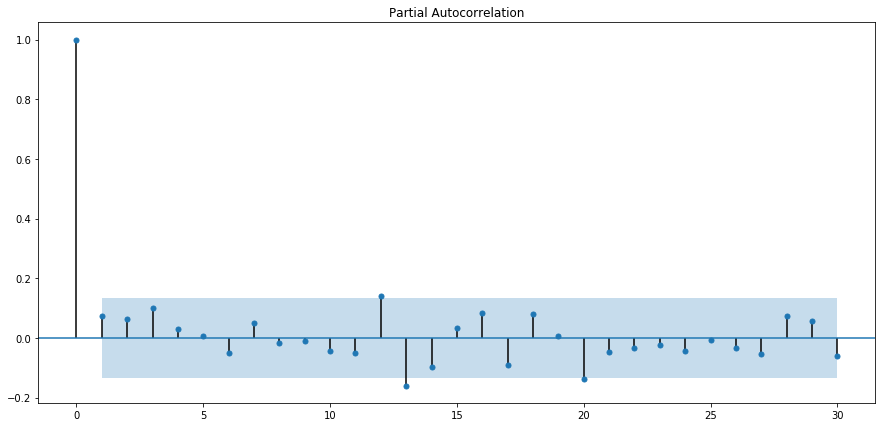

In [15]:
# ACF plot of the first order differenced data
smt.graphics.tsa.plot_acf(monthly_ts_diff, lags = 30, alpha = 0.05)
plt.show()

# PACF plot of the first order differenced data
smt.graphics.tsa.plot_pacf(monthly_ts_diff, lags = 30, alpha = 0.05)
plt.show()

### Manually fitting ARIMA model

After applying log transformation and first order differencing, we can see that the ACF cuts off fairly quickly. This means that the data can now be considered stationary.

As per the lecture slides: When both ACF and PACF die down quickly, check the orders at which ACF or PACF die down. The order of ACF will be the lag q of the ARIMA and the order of PACF will be the lag p of the ARIMA, and the order of difference will be d.

In this case: ACF order = 0, PACF order = 0, d = 1

In [16]:
# ARIMA(0,1,0) model
model_ARIMA = ARIMA(training_subset_log, order = (0, 1, 0))  

# Fitting the data
fit_ARIMA = model_ARIMA.fit(disp = -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


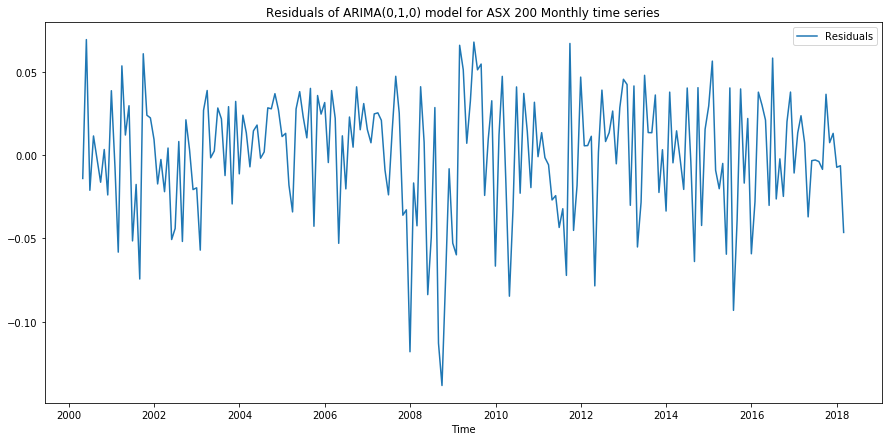

In [17]:
# Checking the residuals
residuals_ARIMA = pd.DataFrame(fit_ARIMA.resid)

plt.plot(residuals_ARIMA, label = "Residuals")
plt.xlabel('Time')
plt.title('Residuals of ARIMA(0,1,0) model for ASX 200 Monthly time series')
plt.legend()

In [18]:
# Forecasting 'Close' price for next 12 months (validation subset)
results_ARIMA = fit_ARIMA.predict(end=training_subset_log.size+11, typ='levels', dynamic=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [0]:
# Returning data to its original form by taking inverse of log
predictions_ARIMA = np.exp(results_ARIMA)

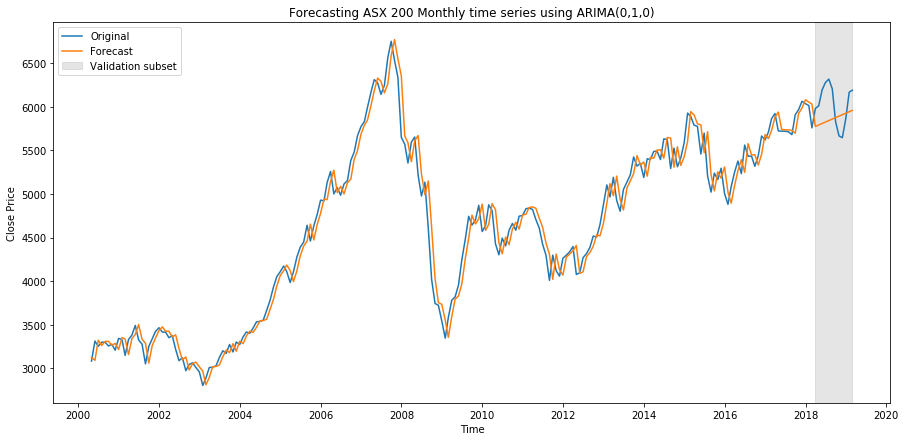

In [20]:
# Plot of Actual vs Forecasted data
plt.plot(monthly_ts[1:], label="Original")
plt.plot(predictions_ARIMA, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Forecasting ASX 200 Monthly time series using ARIMA(0,1,0)')
plt.legend()

In [21]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset[1:], predictions_ARIMA[:-12]))
MAE = mean_absolute_error(training_subset[1:], predictions_ARIMA[:-12])
MAPE = np.mean(np.abs((training_subset[1:] - predictions_ARIMA[:-12]) / training_subset[1:])) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 172.16969261691338
Mean Absolute Error (MAE): 133.88854721159643
Mean Absolute Percentage Error (MAPE): 2.936532427830423


In [22]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_ARIMA[-12:]))
MAE = mean_absolute_error(validation_subset, predictions_ARIMA[-12:])
MAPE = np.mean(np.abs((validation_subset - predictions_ARIMA[-12:]) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 292.45623103756753
Mean Absolute Error (MAE): 262.1626415738095
Mean Absolute Percentage Error (MAPE): 4.351230229247803


### Auto-ARIMA model

In [23]:
# Using auto-ARIMA to tune hyperparameters
autoARIMA_model = auto_arima(training_subset_log, start_p=0, start_q=0, m=12,
                          start_P=0, start_Q=0, seasonal=True, d=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

autoARIMA_model.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=-805.875, BIC=-799.134, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=-807.080, BIC=-793.598, Fit time=0.523 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=-807.218, BIC=-793.736, Fit time=0.566 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=-806.218, BIC=-789.365, Fit time=1.119 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=-804.907, BIC=-794.795, Fit time=0.057 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 2, 12); AIC=-805.771, BIC=-788.917, Fit time=2.259 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=-804.219, BIC=-783.995, Fit time=3.736 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=-807.188, BIC=-797.076, Fit time=0.314 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  216
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 407.609
Date:                            Mon, 20 May 2019   AIC                           -807.218
Time:                                    12:04:22   BIC                           -793.736
Sample:                                         0   HQIC                          -801.771
                                            - 216                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0028      0.004      0.797      0.426      -0.004       0.010
ma.L1          0.0930      0.054      1.716      0.086      -0.013       0.199
ma.S.L12       0.1545      0.074      2.086      0.037       0.009       0.300
sigma2         0.0013      0.000     10.690      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       31.34   Jarque-Bera (JB):                24.71
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.71
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model chosen by auto-ARIMA is ARIMA(0,1,1)(0,0,1)[12]

In [0]:
# ARIMA(0,1,1)(0,0,1)[12] model
train_model = autoARIMA_model.fit(training_subset_log)

In [0]:
# Calculating fitted values
fitted_values = training_subset_log + train_model.resid()

In [0]:
# Forecasting 'Close' price for next 12 months (validation subset)
results_autoARIMA = train_model.predict(n_periods=12)

In [0]:
# Converting results into a time series
results_autoARIMA = pd.Series(results_autoARIMA, index=monthly_ts.index[-12:])

In [0]:
# Appending fitted values with the predicted values
predictions_autoARIMA = fitted_values.append(results_autoARIMA)

In [0]:
# Returning data to its original form by taking inverse of log
predictions_autoARIMA = np.exp(predictions_autoARIMA)

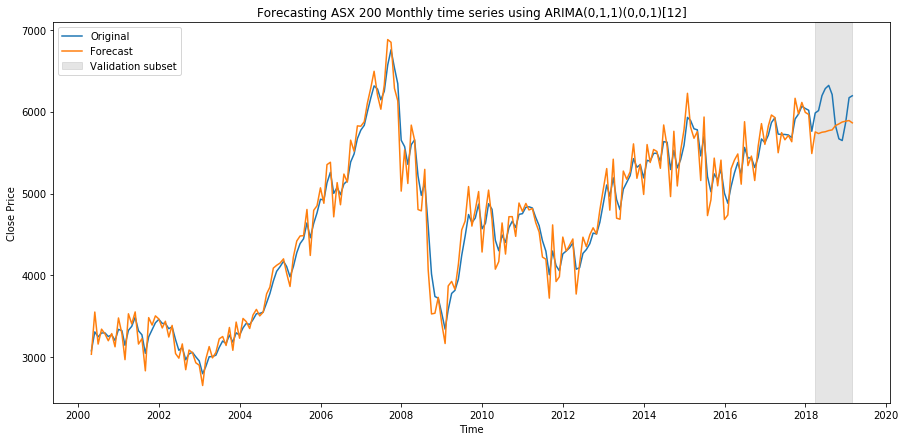

In [30]:
predictions_autoARIMA = predictions_autoARIMA[1:]

# Plot of Actual vs Forecasted data
plt.plot(monthly_ts[1:], label="Original")
plt.plot(predictions_autoARIMA, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Forecasting ASX 200 Monthly time series using ARIMA(0,1,1)(0,0,1)[12]')
plt.legend()

In [31]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset[1:], predictions_autoARIMA[:-12]))
MAE = mean_absolute_error(training_subset[1:], predictions_autoARIMA[:-12])
MAPE = np.mean(np.abs((training_subset[1:] - predictions_autoARIMA[:-12]) / training_subset[1:])) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 165.22623360197306
Mean Absolute Error (MAE): 128.65432650047546
Mean Absolute Percentage Error (MAPE): 2.8313412407040928


In [32]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_autoARIMA[-12:]))
MAE = mean_absolute_error(validation_subset, predictions_autoARIMA[-12:])
MAPE = np.mean(np.abs((validation_subset - predictions_autoARIMA[-12:]) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 337.9431859952896
Mean Absolute Error (MAE): 291.97397293480805
Mean Absolute Percentage Error (MAPE): 4.765759837595676
